# Análise dos Resultados da Otimização dos Parâmetros

# Índice:
   * [Descrição](#description)
      * [Objetivos](#goals)
   * [Imports](#imports)
   * [Recuperação dos Dados do MLFlow](#recover)
       *[Modelos](#recoverModels)
       *[Resultados](#recoverResults)
   * [Análise](#analysis)
      * [Plot de Coordenadas Paralelas](#parallel)
      * [Plos de Desemepenho](#plotScore)
      * [Estrutura das Árvores](#treeStructure)
      * [Importância das Características](#featureImportance)
      * [p-valor](#pvalue)

In [1]:
%pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 7.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 1.3 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Descrição<a class="anchor" id="description"></a>

Esse notebook recupera os dados da busca de híper-parâmetros e analisa os resultados. São analisados o desempenho dos modelos nos testes, as estruturas de árvores com diferentes parâmetros e a importância das características utilizadas.

### Objetivos<a class="anchor" id="goals"></a>
   * Entender como os parâmetros de uma árvore de decisão influenciam sua estrutura e no seu desempenho no problema.
   * Apontar parâmetros ideais para o modelo baseado árvore de decisão para o problema.


## Imports

In [21]:
from time import time
import tempfile
import os

import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
from mlflow.entities import ViewType
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl


## Conexão com o MLflow

Para exeutar a conexão, é necessário passar o endereço de IP da máquina que hospeda o container que está rondando o MLflow. No bash, isso pode ser feito com $ip r.

In [3]:
def connectMLFlow(MLFlowAddr):
    client = MlflowClient(tracking_uri=MLFlowAddr)
    mlflow.set_tracking_uri(MLFlowAddr)
    return client

In [4]:
client = connectMLFlow("http://172.27.0.1:5000")

In [5]:
experiments =mlflow.get_experiment_by_name("ModelsSearch")
Treeexperiments =mlflow.get_experiment_by_name("HiperParameter Search")
Linearexperiments = mlflow.get_experiment_by_name("Simple Model")
VGGexperiments = mlflow.get_experiment_by_name("VGG16 Model")
VGGexperiments

<Experiment: artifact_location='s3://mlflow/77', experiment_id='77', lifecycle_stage='active', name='VGG16 Model', tags={}>

In [6]:
runs = mlflow.search_runs(experiments.experiment_id, output_format = "list")
treeRuns = mlflow.search_runs(Treeexperiments.experiment_id, output_format = "list")
linearRuns = mlflow.search_runs(Linearexperiments.experiment_id, output_format = "list")
vggRuns = mlflow.search_runs(VGGexperiments.experiment_id, output_format = "list")

In [7]:
run_names = [run.data.tags['mlflow.runName'] for run in runs]
treeRun_names = [run.data.tags['mlflow.runName'] for run in treeRuns]
linearRun_names = [run.data.tags['mlflow.runName'] for run in linearRuns]
vggRun_names = [run.data.tags['mlflow.runName'] for run in vggRuns]
vggRun_names

['PCA', 'PCA', 'LinearRegression']

In [8]:
picked_runs = [linearRuns[0],treeRuns[0],runs[4],runs[5],runs[0],vggRuns[2], vggRuns[0]]

In [9]:
picked_runs_names = [run.data.tags['mlflow.runName'] for run in picked_runs[0:5]]

picked_runs_names.append("VGG16 Linear Regression")
picked_runs_names

['LinearRegression',
 'DecisionTree GridSearch',
 'KNeighbors RandomSearch',
 'RandomForest RandomSearch',
 'NeuralNetwork RandomSearch',
 'VGG16 Linear Regression']

## Funções Auxiliares

Nesta parte são defenidas funções para carregar os dados do MLflow, para imprimir esses dados, para carregá-los em um DataFrame, para selecioná-los e para plotar os resultados. 

In [10]:
def recoverSearchRun(run):
    #test_random_state = int(run.data.tags["test_random_state"])
    #test_size = float(run.data.tags["test_size"])
    #split_params = [test_random_state, test_size]
    
    #model_params = eval(run.data.params["param_distributions"])
    
    uri = run.info.artifact_uri
    model = mlflow.sklearn.load_model(uri+"/model")
    
    #results = recoverResultsCSV(uri+"/cv_results")
    
    return  model 
    
    

In [11]:
models = []
for run in picked_runs:
    model= recoverSearchRun(run)
    models.append(model)

In [12]:
models

[LinearRegression(),
 DecisionTreeRegressor(max_depth=9, min_samples_leaf=35, min_samples_split=125,
                       random_state=10),
 KNeighborsRegressor(leaf_size=5, n_neighbors=95),
 RandomForestRegressor(max_depth=10, max_leaf_nodes=550, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=151, random_state=10),
 MLPRegressor(alpha=0.01, hidden_layer_sizes=(20, 15), max_iter=1500,
              random_state=10, solver='lbfgs'),
 LinearRegression(),
 PCA(n_components=300)]

In [22]:
def cross_validation(model, _X, _y, _cv):
    _scoring = ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"]
    results = cross_validate(estimator=model, X=_X, y=_y, cv=_cv, scoring=_scoring)
    return results

def eval_metrics_cv(cv):
    rmse = cv["test_neg_root_mean_squared_error"].mean()
    rmseStd = cv["test_neg_root_mean_squared_error"].std()
    mae = cv["test_neg_mean_absolute_error"].mean()
    maeStd = cv["test_neg_mean_absolute_error"].std()
    r2 = cv["test_r2"].mean()
    r2Std = cv["test_r2"].std()
    return {
            "rmse":[rmse, rmseStd],
            "mae":[mae, maeStd], 
            "r2":[r2, r2Std]
           }

def print_metrics_cv(scores):
    for metric, score in scores.items():
        mean = score[0]
        std = score[1]
        print (f"{metric}: {mean:.2f} +/- {2*std:.2f}")



In [151]:
print("Hello Wolrd")

Hello Wolrd


In [135]:
testscores = []
results = cross_validation(models[5],pcaX_testYGG, y_testYGG, 5)
score = eval_metrics_cv(results)
print_metrics_cv(score)
scores.append(score)
print (testscores)

rmse: -11.20 +/- 0.83
mae: -8.83 +/- 0.61
r2: 0.47 +/- 0.09
[]


In [38]:
scores = []
for model in models[5]:
    results = cross_validation(model,X_train, y_train, 5)
    score = eval_metrics_cv(results)
    print_metrics_cv(score)
    scores.append(score)

rmse: -13.86 +/- 0.59
mae: -10.95 +/- 0.27
r2: 0.20 +/- 0.06
rmse: -13.18 +/- 0.47
mae: -10.24 +/- 0.28
r2: 0.28 +/- 0.05
rmse: -14.07 +/- 0.51
mae: -11.19 +/- 0.25
r2: 0.18 +/- 0.05
rmse: -12.80 +/- 0.54
mae: -9.91 +/- 0.22
r2: 0.32 +/- 0.05


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


rmse: -13.57 +/- 0.61
mae: -10.69 +/- 0.31
r2: 0.24 +/- 0.07


In [39]:
scores

[{'rmse': [-13.860161562414874, 0.2929946693193988],
  'mae': [-10.948623501053358, 0.13425833885592772],
  'r2': [0.20445172539737427, 0.028075902894869595]},
 {'rmse': [-13.178971077822874, 0.23594599667364208],
  'mae': [-10.243382402845068, 0.14022922350682113],
  'r2': [0.28065386290215055, 0.0248920162263898]},
 {'rmse': [-14.069675625516131, 0.2574138430658451],
  'mae': [-11.186636810846464, 0.12558743845832332],
  'r2': [0.1802627118160472, 0.02485050870192451]},
 {'rmse': [-12.796080455278311, 0.26886091384640487],
  'mae': [-9.909255975264674, 0.1102742577604308],
  'r2': [0.321793017133308, 0.026949610591661073]},
 {'rmse': [-13.567897780385206, 0.30718157388957573],
  'mae': [-10.69047707567142, 0.15696811776421535],
  'r2': [0.23743816020182437, 0.033112803868715124]}]

In [35]:
results = cross_validation(models[3],X, y, 5)

scores = eval_metrics_cv(results)

print_metrics_cv(scores)

rmse: -12.74 +/- 0.47
mae: -9.87 +/- 0.32
r2: 0.32 +/- 0.04


In [93]:
objects = []
with (open("../extracao/keras.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pkl.load(openfile))
        except EOFError:
            break


In [24]:
def read_data(url):
    return pd.read_csv(os.path.abspath(url))
df = read_data("../extracao/datanov2.csv")
def getXy(df):
    r_state = 15
    df = shuffle(df, random_state=r_state)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X, y
r_state = 10
X, y = getXy(df)
X_train, X_test, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=10
)


In [94]:
XYGG = pd.DataFrame([o[1] for o in objects])


In [95]:
yYGG = pd.DataFrame([o[2] for o in objects])

In [96]:
X_trainYGG, X_testYGG, y_trainYGG, y_testYGG = train_test_split(
    XYGG, yYGG, test_size=0.3, random_state=10
)


In [97]:
models[-1]

PCA(n_components=300)

In [98]:
pcaX_testYGG = models[-1].transform(X_testYGG)


In [40]:
picked_runs_names

['LinearRegression',
 'DecisionTree GridSearch',
 'KNeighbors RandomSearch',
 'RandomForest RandomSearch',
 'NeuralNetwork RandomSearch',
 'VGG16 Linear Regression']

In [46]:
performance_data = {"Models":picked_runs_names[0:5],"Mean Absolute Error":[s['r2'][0] for s in scores]}


In [47]:
performance_data

{'Models': ['LinearRegression',
  'DecisionTree GridSearch',
  'KNeighbors RandomSearch',
  'RandomForest RandomSearch',
  'NeuralNetwork RandomSearch'],
 'Mean Absolute Error': [0.20445172539737427,
  0.28065386290215055,
  0.1802627118160472,
  0.321793017133308,
  0.23743816020182437]}

In [53]:

def plot_confidence_interval(x, mean, stdev, n, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    confidence_interval = z * stdev / sqrt(n)

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval


In [50]:
import statistics
from math import sqrt


In [149]:

def confidencePlot(metric,scores):
    plt.xticks([1, 2, 3, 4,5,6], ['RL', 'AD', 'KV', 'FA','NN','VGG'])
    
    i = 0
    a = -1
    if metric == 'r2':
        a = 1
    for score in scores:
        i+=1
        plot_confidence_interval(i, a * score[metric][0], score[metric][1],5)
    #plot_confidence_interval(2, [10, 21, 42, 45, 44])
    #plot_confidence_interval(3, [20, 2, 4, 45, 44])
    #plot_confidence_interval(4, [30, 31, 42, 45, 44])
    plt.savefig(f'{metric}_results.pdf')
    plt.show()

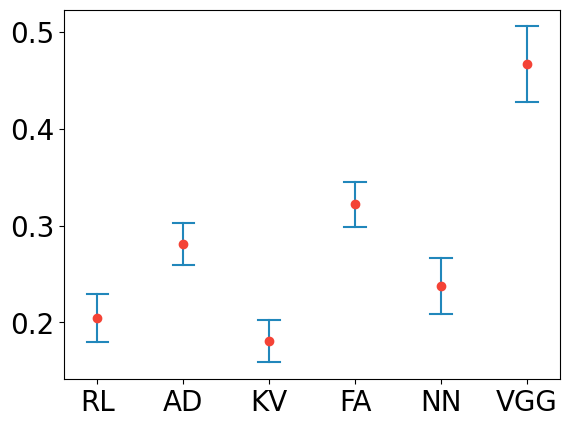

In [147]:
plt.rc('font', size=20)
confidencePlot('r2',scores)

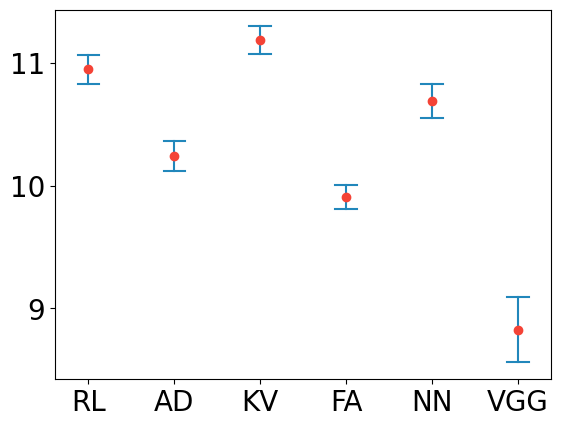

In [148]:
confidencePlot('mae',scores)

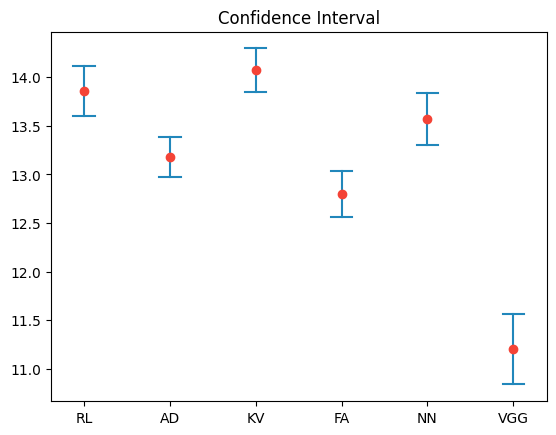

In [139]:
confidencePlot('rmse',scores)

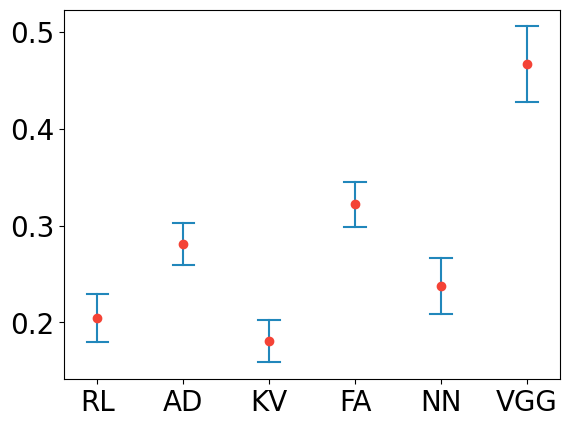

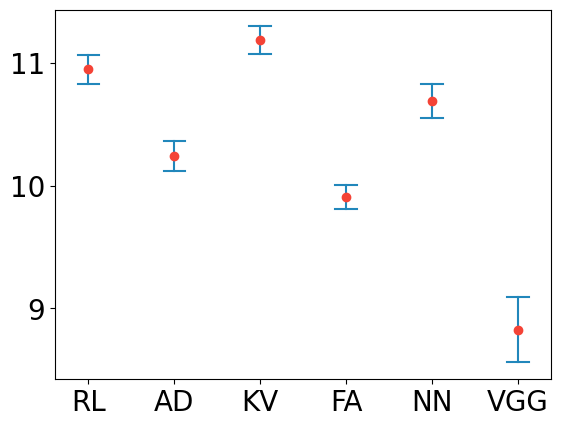

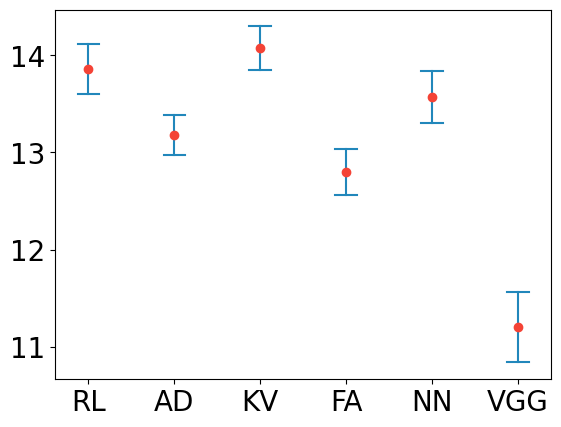

In [150]:
for score in ['r2','mae','rmse']:
    confidencePlot(score,scores)

In [145]:
scores

[{'rmse': [-13.860161562414874, 0.2929946693193988],
  'mae': [-10.948623501053358, 0.13425833885592772],
  'r2': [0.20445172539737427, 0.028075902894869595]},
 {'rmse': [-13.178971077822874, 0.23594599667364208],
  'mae': [-10.243382402845068, 0.14022922350682113],
  'r2': [0.28065386290215055, 0.0248920162263898]},
 {'rmse': [-14.069675625516131, 0.2574138430658451],
  'mae': [-11.186636810846464, 0.12558743845832332],
  'r2': [0.1802627118160472, 0.02485050870192451]},
 {'rmse': [-12.796080455278311, 0.26886091384640487],
  'mae': [-9.909255975264674, 0.1102742577604308],
  'r2': [0.321793017133308, 0.026949610591661073]},
 {'rmse': [-13.567897780385206, 0.30718157388957573],
  'mae': [-10.69047707567142, 0.15696811776421535],
  'r2': [0.23743816020182437, 0.033112803868715124]},
 {'rmse': [-11.20206739429418, 0.414814307413586],
  'mae': [-8.826729062778508, 0.3047198054126655],
  'r2': [0.46686829176533795, 0.044414670756182176]}]

In [125]:
def corr(model,X_test,y_val):

    predicted_actual = {
        "True values": list(y_val.values.flatten()), "Predicted values": list(model.predict(X_test))}
    predicted_actual = pd.DataFrame(predicted_actual)

    srcc = predicted_actual.corr(method='spearman')["True values"][1]
    pcc = predicted_actual.corr(method='pearson')["True values"][1]
    return (srcc, pcc) 

In [128]:
#(corr (models[-2], pcaX_testYGG,y_testYGG))
predicted_actual = {
    "True values": list(y_testYGG.values.flatten()), "Predicted values": list(models[-2].predict(pcaX_testYGG).flatten())}


In [153]:
teste = predicted_actual["True values"] - predicted_actual["Predicted values"]

In [154]:
teste.mean()

-0.09313919883194498

In [107]:
predicted_actual

{'True values': array([[57.84174312],
        [57.22815534],
        [30.7961165 ],
        ...,
        [60.60810811],
        [67.30841121],
        [65.30373832]]),
 'Predicted values': array([[71.40408 ],
        [61.12809 ],
        [52.555897],
        ...,
        [62.861763],
        [69.65645 ],
        [58.458046]], dtype=float32)}

In [133]:
predicted_actual = pd.DataFrame(predicted_actual)

srcc = predicted_actual.corr(method='spearman')["True values"][1]
pcc = predicted_actual.corr(method='pearson')["True values"][1]
print(srcc,pcc)

0.6780310320652617 0.6975888905808353


In [92]:
for model in models[0:5]:
    print (corr(model, X_test,y_val))

(0.4100880543212314, 0.4304099297323195)
(0.5051843355841972, 0.5125535391637079)
(0.33670357604506185, 0.40349132561348905)
(0.5421437703223747, 0.5506519474183444)
(0.40429161373853045, 0.436448114245313)


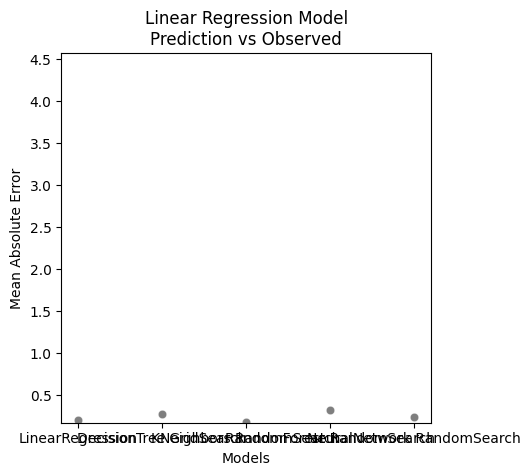

In [48]:
sns.scatterplot(data=performance_data,
                x="Models", y="Mean Absolute Error",
                color="black", alpha=0.5)
plt.axis('square')
_ = plt.title("Linear Regression Model\nPrediction vs Observed")

In [26]:
def plot_param_r2(df,param,ax):
    min_samples_group = df.groupby([param], as_index=False)['mean_test_r2'].mean()

    #plt.figure()
    ax.plot(min_samples_group[param],min_samples_group["mean_test_r2"])
    ax.set(xlabel=param, ylabel="r2", title=param)


    #plt.show()


In [45]:
def plot_predicted(model, ax):
    predicted_actual = {
        "True values": y_val, "Predicted values": model.predict(X_test)}
    predicted_actual = pd.DataFrame(predicted_actual)

    sns.scatterplot(data=predicted_actual,
                    x="True values", y="Predicted values",
                    color="black", alpha=0.5)#, ax=ax)
    ax.axline((0, 0), slope=1, label="Perfect fit")
    ax.axis('square')
    #_t = ax.title(title)
    #ax.title("Decision Tree Model\nPrediction vs Observed")

[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]


(-4.419444444444445, 95.9962919447157, -4.564351654052735, 95.85138473510742)

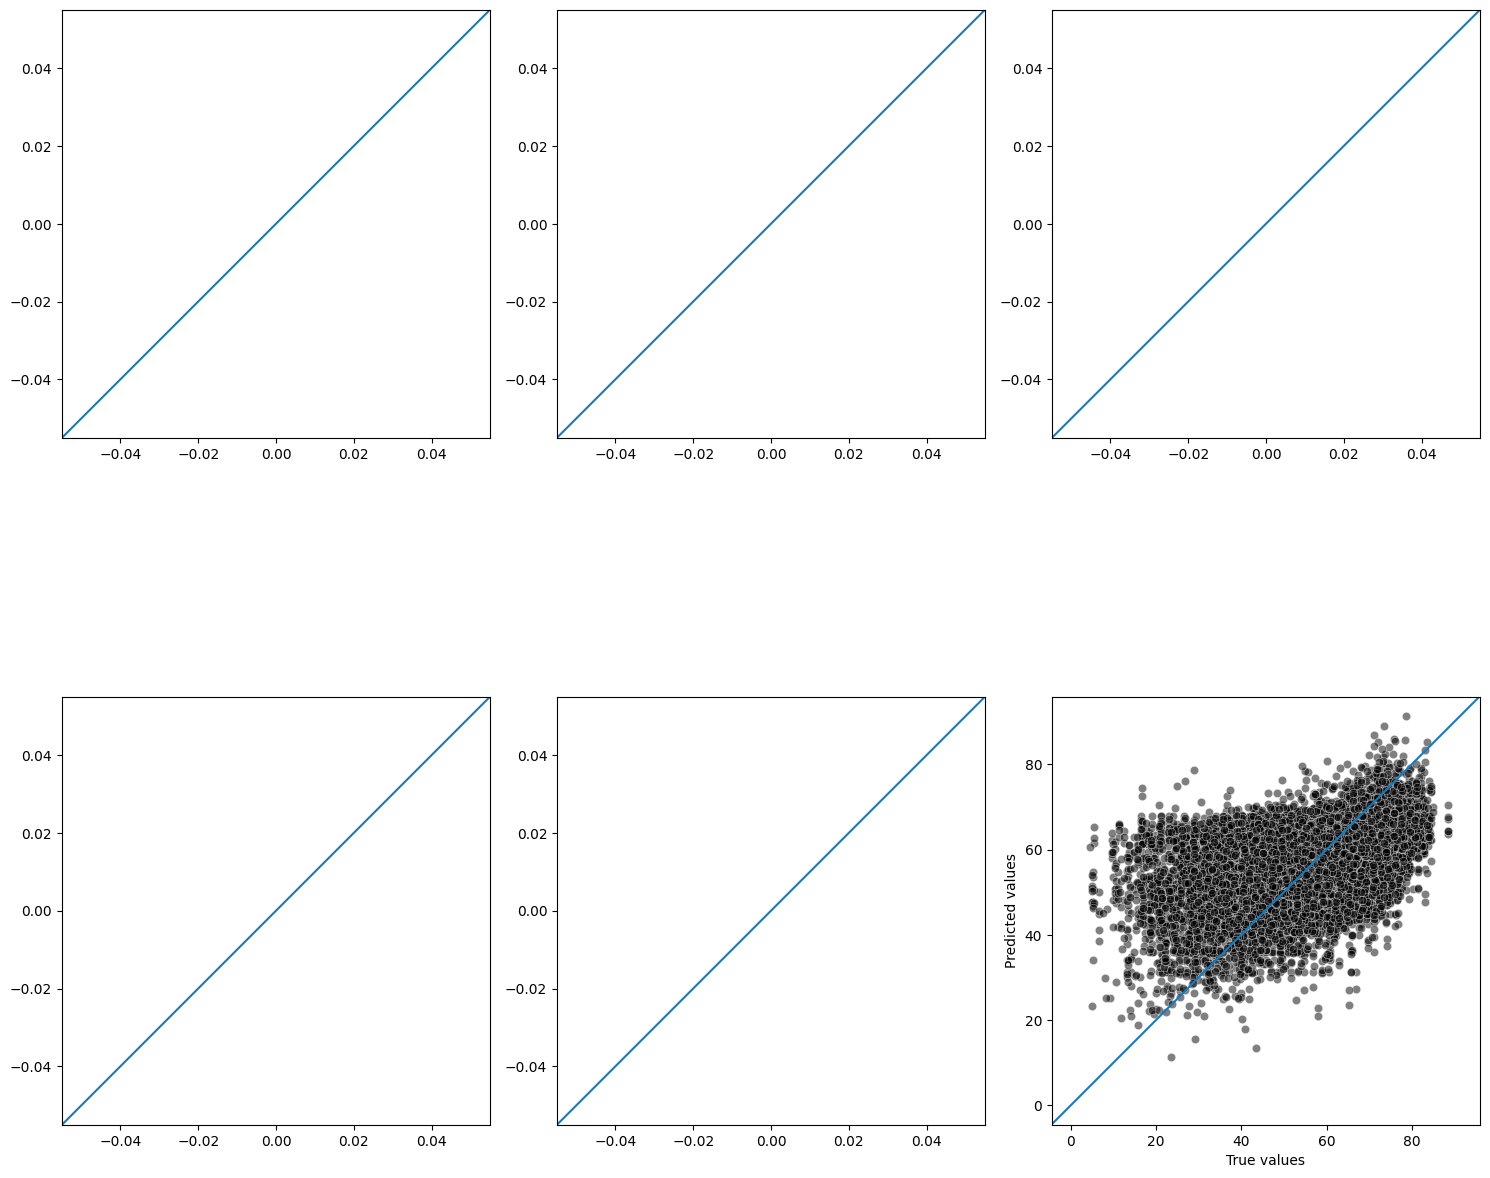

In [48]:
plot, axs = plt.subplots(2,3,figsize=(15, 15))
print (axs)
i = 0
j = 0

for model in models[0:5]:
    plot_predicted(model, axs[i][j])
    i+=1
    if i == 2:
        i = 0
        j += 1
#plt.subplots_adjust(bottom=0.1, right=1.8, top=2.5)
plot.tight_layout()
#axs[0].plot(x,y)
#plot_param_r2(df, "param_max_depth",axs[1])


sns.scatterplot(data=predicted_actualYGG,
                x="True values", y="Predicted values",
                color="black", alpha=0.5,ax=axs[1][2])
plt.axline((0, 0), slope=1, label="Perfect fit")

axs[1][2].axis('square')

In [ ]:
['LinearRegression',
 'DecisionTree GridSearch',
 'KNeighbors RandomSearch',
 'RandomForest RandomSearch',
 'NeuralNetwork RandomSearch',
 'LinearRegression',
 'PCA']

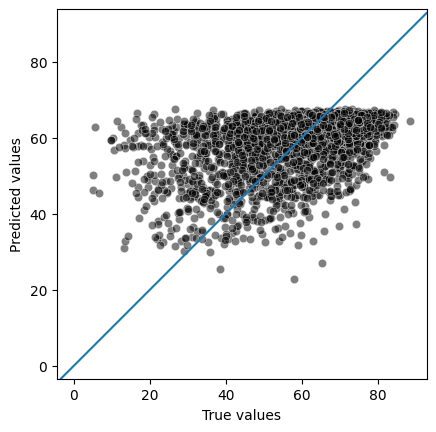

In [47]:
  plot_predicted(models[4], plt)

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]
dict_keys(['max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators', 'max_leaf_nodes'])


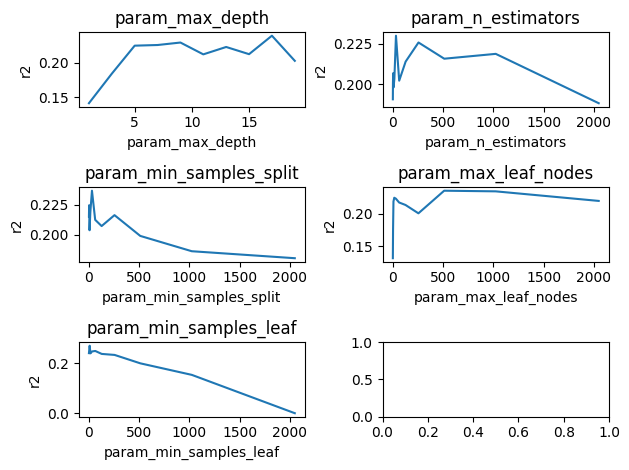

In [94]:
plot, axs = plt.subplots(3,2)
print (axs)
i = 0
j = 0
print (model_params.keys())
for name in model_params.keys():
    plot_param_r2(results, "param_" + name, axs[i][j])
    i+=1
    if i == 3:
        i = 0
        j = 1
#plt.subplots_adjust(bottom=0.1, right=1.8, top=2.5)
plot.tight_layout()
#axs[0].plot(x,y)
#plot_param_r2(df, "param_max_depth",axs[1])